In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
import os

Using TensorFlow backend.


### We have to load the Amazon Fine Food Reviews Dataset from the storage to colab

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:33<00:00, 2634.76it/s]


In [26]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
final['CleanedText']=preprocessed_reviews

conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(87773, 12)

In [28]:
positive_points = cleaned_data[cleaned_data['Score'] == 1]
negative_points = cleaned_data[cleaned_data['Score'] == 0]
total_points = pd.concat([positive_points, negative_points])
print(total_points)
print(total_points.shape)

       index  ...                                        CleanedText
1      22621  ...  dogs love saw pet store tag attached regarding...
5      70673  ...  happy item many flies disturbing kitchen put p...
7      70671  ...  nurturing plant work well decided repot larger...
22     70685  ...  used traditional fly rolls past dubious hubby ...
26     70687  ...  sly trap attractive look works well no odor re...
...      ...  ...                                                ...
87743  90976  ...  close eyes try really hard might able pick fei...
87750  58909  ...  item good way overpriced vendor buy mix direct...
87763  63441  ...  unimpressed almonds clovey musty taste expecti...
87770  35419  ...  trader joe product good quality buy straight t...
87771   1362  ...  coffee supposedly premium tastes watery thin n...

[87773 rows x 12 columns]
(87773, 12)


In [29]:
total_points['Time'] = pd.to_datetime(
total_points['Time'], origin='unix', unit='s')
total_points = total_points.sort_values('Time')
sample_points = total_points['CleanedText'].values
labels = total_points['Score']

print(total_points.shape)
print(sample_points.shape)
print(labels.shape)

(87773, 12)
(87773,)
(87773,)


In [0]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ', lower=True,)
# fit the tokenizer on the documents
t.fit_on_texts(sample_points)
sequences = t.texts_to_sequences(sample_points)

In [0]:
word_counts=t.word_counts
print('Found %s unique tokens.' % len(word_counts))
print(word_counts)
word_index=t.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)
#document_count:An integer count of the total number of documents that were used to fit the Tokenizer.
document_count=t.document_count
print('Found %s unique tokens.' % (document_count))
print(document_count)
#word_docs: A dictionary of words and how many documents each appeared in.
word_docs=t.word_docs
print('Found %s unique tokens.' %len(word_docs))
print(word_docs)

## We will convert the data to the type of IMDb Data 

**For the frequency of the words in the dataset to rank, we can use both Count Vectorizer and TfIdf Vectorizer to convert to vectors. Here we use Count Vectorizer to get the word vectors***

In [0]:
X=sample_points
y=labels

In [33]:
vect=CountVectorizer()
vect.fit(X)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [34]:
features=vect.get_feature_names()
print("The total no of words are",len(features))


The total no of words are 54904


In [0]:
corpus=dict()
i=0
for sent in X:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(i)
    i+=1

freq = []
for w in features:
  freq.append(len(corpus[w]))

In [0]:
index =np.argsort(np.array(freq))[::-1]


In [0]:
word_rank = dict()
rank = 1
for ix in index:
  word_rank[features[ix]] = rank
  rank +=1

In [38]:
print(len(X))

87773


In [0]:
data = []
count=0
for sent in X:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.5,random_state=42)

In [42]:
print(X_train[32])

[8646, 366, 57, 533, 438, 38, 104, 59, 68, 532, 26]


In [43]:
"""#Refer: https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)"""
print("")

In [44]:
print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[13842, 1, 59, 741, 14, 5159, 1302, 3320, 741, 475, 213, 988, 41, 1181, 4217, 645, 41, 660, 213]
<class 'list'>
19


In [45]:
# truncate and/or pad input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[32])

(43886, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 8646  366   57  533  438   38  104   59   68
  532   26]


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
np.random.seed(7)

## 1-LSTM LAYER

In [0]:
# create the model
embedding_vecor_length = 32
model = Sequential()

model.add(Embedding(len(features)+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 32)           1756960   
_________________________________________________________________
dropout_18 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 1,810,261
Trainable params: 1,810,261
Non-trainable params: 0
_________________________________________________________________


In [0]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, y_train, nb_epoch=10, batch_size=64,verbose=1, validation_data=(X_test, y_test))
# Final evaluation of the model


Train on 43886 samples, validate on 43887 samples
Epoch 1/10
Train on 43886 samples, validate on 43887 samples
Epoch 1/10
43886/43886 [==============================] - 152s 3ms/step - loss: 0.2705 - acc: 0.8968 - val_loss: 0.2138 - val_acc: 0.9170
Epoch 2/10
43886/43886 [==============================] - 147s 3ms/step - loss: 0.1632 - acc: 0.9394 - val_loss: 0.2169 - val_acc: 0.9134
Epoch 3/10
43886/43886 [==============================] - 147s 3ms/step - loss: 0.1269 - acc: 0.9541 - val_loss: 0.2625 - val_acc: 0.9128
Epoch 4/10
43886/43886 [==============================] - 148s 3ms/step - loss: 0.0987 - acc: 0.9647 - val_loss: 0.2835 - val_acc: 0.9123
Epoch 5/10
43886/43886 [==============================] - 146s 3ms/step - loss: 0.0814 - acc: 0.9712 - val_loss: 0.2970 - val_acc: 0.9116
Epoch 6/10
43886/43886 [==============================] - 147s 3ms/step - loss: 0.0634 - acc: 0.9787 - val_loss: 0.3278 - val_acc: 0.9093
Epoch 7/10
43886/43886 [==============================] - 148

In [0]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.4399654851703875
Test accuracy: 0.9050743956082576


In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
nb_epoch=10

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

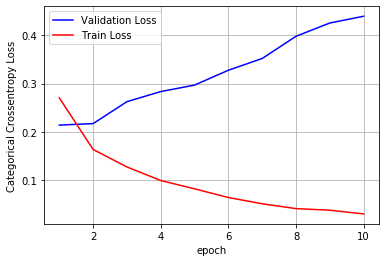

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## 2- LSTM LAYER

In [0]:
embedding_vecor_length = 32

# Initialising the model
model_2 = Sequential()

# Adding embedding
model_2.add(Embedding(len(features)+1, embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_2.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

# Adding second LSTM layer
model_2.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

# Adding output layer
model_2.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_2.summary())

# Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_2 = model_2.fit(X_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 32)           1756960   
_________________________________________________________________
lstm_25 (LSTM)               (None, 100, 100)          53200     
_________________________________________________________________
lstm_26 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 1,890,661
Trainable params: 1,890,661
Non-trainable params: 0
_________________________________________________________________
None
Train on 43886 samples, validate on 43887 samples
Epoch 1/10
43886/43886 [==============================] - 254s 6ms/step - loss: 0.4014 - acc: 0.8477 - val_loss: 0.2578 - val_acc: 0.8973
Epoch 2/10
43886/43886 [========================

In [0]:
score = model_2.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.34723274353832617
Test accuracy: 0.9025451728315812


In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

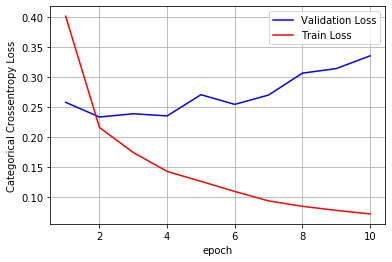

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history_2.history['val_loss']
ty = history_2.history['loss']
plt_dynamic(x, vy, ty, ax)

## 3-LSTM LAYERS

In [47]:
embedding_vecor_length = 32

# Initialising the model
model3 = Sequential()

# Adding embedding
model3.add(Embedding(len(features)+1, embedding_vecor_length, input_length=max_review_length))

model3.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))

model3.add(LSTM(100,return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

model3.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))

model3.add(Dense(1, activation='sigmoid'))

print(model3.summary())

# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           1756960   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,971,061
Trainable params: 1,971,061
Non-trainable params: 0
_________________________________________________________

In [48]:
history3 = model3.fit(X_train, y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))
score = model3.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])




Train on 43886 samples, validate on 43887 samples
Epoch 1/10





43886/43886 [==============================] - 361s 8ms/step - loss: 0.4094 - acc: 0.8469 - val_loss: 0.2608 - val_acc: 0.8919
Epoch 2/10
43886/43886 [==============================] - 355s 8ms/step - loss: 0.2199 - acc: 0.9136 - val_loss: 0.2345 - val_acc: 0.9072
Epoch 3/10
43886/43886 [==============================] - 353s 8ms/step - loss: 0.1728 - acc: 0.9350 - val_loss: 0.2296 - val_acc: 0.9089
Epoch 4/10
43886/43886 [==============================] - 354s 8ms/step - loss: 0.1446 - acc: 0.9477 - val_loss: 0.2425 - val_acc: 0.9121
Epoch 5/10
43886/43886 [==============================] - 353s 8ms/step - loss: 0.1236 - acc: 0.9556 - val_loss: 0.2510 - val_acc: 0.9114
Epoch 6/10
43886/43886 [==============================] - 352s 8ms/step - loss: 0.1093 - acc: 0.9616 - val_loss: 0.2698 - val_acc: 0.9112
Epoch 7/10
43886/43886 [==============================] - 351s 8ms/step - loss: 0.0971 - acc: 0.9664 - val_loss: 0

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
nb_epoch=10

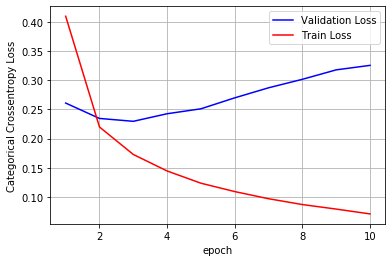

In [52]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history3.history['val_loss']
ty = history3.history['loss']
plt_dynamic(x, vy, ty, ax)

## CONCLUSION

In [53]:
from prettytable import PrettyTable

x= PrettyTable()

x.field_names=(['No of LSTM Layers','Test Score','Test Accuracy'])
x.add_row(['1-LSTM Layer',0.43,0.905])
x.add_row(['2-LSTM Layers',0.34,0.902])
x.add_row(['3-LSTM Layers',0.32,0.903])

print(x)

+-------------------+------------+---------------+
| No of LSTM Layers | Test Score | Test Accuracy |
+-------------------+------------+---------------+
|    1-LSTM Layer   |    0.43    |     0.905     |
|   2-LSTM Layers   |    0.34    |     0.902     |
|   3-LSTM Layers   |    0.32    |     0.903     |
+-------------------+------------+---------------+


**From the above we have seen that all the type of architectures performed well. 3-LSTM has the least test score and 1-LSTM has the highest test accuracy.**